In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import timeit
import sys
import os
from sklearn.cross_validation import KFold
from collections import OrderedDict
import operator
import random
from sklearn.cluster import KMeans
import numpy as np
import scipy.linalg as LA
import scipy.sparse
import sklearn.utils.arpack as SLA
from sklearn.base import ClassifierMixin
from sklearn.base import BaseEstimator
from sklearn.manifold import spectral_embedding
from pyspark.mllib.clustering import GaussianMixture, GaussianMixtureModel
import sklearn.metrics.pairwise as pairwise
from sklearn import decomposition as pca
from scipy import interpolate as ip
import sklearn.mixture as mixture
import sys
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.neighbors import DistanceMetric
from pyspark.sql import SQLContext
from pyspark.sql.types import *
%matplotlib inline

dataX,dataY=datasets.make_blobs(n_samples=10000, n_features=5, centers=2, cluster_std=1.5, center_box=(-10.0, 10.0), shuffle=True, random_state=None)

def labelremover(X,y):
    newX1 = np.around(X,decimals=2)
    newY1=np.copy(y)
    dim = X.shape[1]
    points = np.array(np.empty(len(np.unique(y))))
    knownX = np.empty((len(points),dim))
    knownY = np.empty(len(points))
    for i in np.unique(y):
        points[i] = np.where(y==(i))[0][0]
    for j in np.arange(0,len(newY1)):
        newY1[j]=-1
    for k in np.unique(y):
        newY1[points[k]] = y[points[k]]
    knownX = X[[i for i in points]]
    knownY = y[[i for i in points]]
    print "These are labels of known points: "+ str(knownY)
    return (newY1, knownX, knownY)

trainX = dataX[0:10000,:]
trainY = dataY[0:10000]
testX = dataX[0:10000,:]
testY = dataY[0:10000]


newtrainY, knownX, knownY = labelremover(trainX,trainY)


These are labels of known points: [0 1]


/home/madhura/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [2]:
#Standalone code
X = trainX
y = newtrainY

classes = np.sort(np.unique(y))
PCA = pca.PCA(n_components=X.shape[1])
rotatedData = PCA.fit_transform(X)

#plt.scatter(rotatedData[:,0], rotatedData[:,1], c=trainY, cmap = (('ocean')))

X_ = rotatedData

dim = X_.shape[1]
classes = np.delete(classes, 0) # remove the -1 from this list
k = np.size(classes)

numBins =k+1

def _get_kernel(X, y = None,ker=None):
    
    if ker == "rbf":
        if y is None:
            return pairwise.rbf_kernel(X, X, gamma = 625)
        else:
            return pairwise.rbf_kernel(X, y, gamma = 625)
    elif ker == "linear":
        
        dist = DistanceMetric.get_metric('euclidean')
        if y is None:
            return pairwise.euclidean_distances(X, X)
            #return dist.pairwise(X)
        else:
            return pairwise.euclidean_distances(X, y)
            #return dist.pairwise(X)
    else:
        raise ValueError("is not a valid kernel. Only rbf and euclidean"
                         " are supported at this time")


sig = np.zeros(dim)
gee = np.zeros((numBins,dim))
b_edgeMeans = np.zeros((numBins,dim))
interpolators = []
index = []


for i in range(dim):
    histograms,binEdges = np.histogram(X_[:,i],bins=numBins,density=True)
    #add 0.01 to histograms and normalize it
    histograms = histograms+ 0.01
    #print histograms
    histograms /= histograms.sum()
    # calculating means on the bin edges as the x-axis for the interpolators
    b_edgeMeans[:,i] = np.array([binEdges[j:j + 2].mean() for j in range(binEdges.shape[0] - 1)])
    #print b_edgeMeans
    #get D~, P, W~
    '''
    Wdis = Affinity between discrete points.
    Since Affinity matrix will be build on one histogram at a time. I am using pairwise linear- kernel affinities
    P  = Diagonal matrix of histograms
    Ddis = Diagonal matrix whose diagonal elements are the sum of the columns of PW~P
    Dhat = Diagonal matrix whose diagonal elements are the sum of columns of PW~
    '''
    Wdis = _get_kernel(histograms.reshape(histograms.shape[0],1),y=None,ker="linear")
    #print Wdis
    P  = np.diag(histograms)
    #print P
    Ddis = np.diag(np.sum((P.dot(Wdis.dot(P))),axis=0))
    #print Ddis
    Dhat = np.diag(np.sum(P.dot(Wdis),axis=0))
    #print Dhat
    #Creating generalized eigenfunctions and eigenvalues from histograms.
    sigmaVals, functions = scipy.linalg.eig((Ddis-(P.dot(Wdis.dot(P)))),(P.dot(Dhat)))
    #print functions.shape
    #print("eigenValue"+repr(i)+": "+repr(np.real(sigmaVals[0:self.k]))+"Eigenfunctions"+repr(i)+": "+repr(np.real(functions[:,0:self.k])))
    #print np.sort(np.real(sigmaVals))
    arg = np.argsort(np.real(sigmaVals))[1]
    index.append(arg)
    sig[i] = np.real(sigmaVals)[arg]
    gee[:,i] = np.real(functions)[:,arg]
    #b_edge_for_test[:,i] = b_edgeMeans[:,arg]
    #print "===="
'''for i in index:
    plt.hist(X_[:,i], bins = numBins)
    plt.axis([binEdges.min()-5, binEdges.max()+5, 0, X_.shape[0]])
plt.show()
'''

if np.isnan(np.min(sig)):
    nan_num = np.isnan(sig)
    sig[nan_num] = 0
newsig = np.zeros(k)
newg = np.zeros((numBins,k))
newEdgeMeans = np.zeros((numBins,k))
transformeddata = np.zeros((X_.shape[0],k))
approxValues = np.zeros((X_.shape[0],k))

def get_transformed_data(ori_data,edge_means,i):
    dim = edge_means.shape[1]
    transformeddata = np.empty((ori_data.shape[0],dim))
    if ori_data[:,i].min() < edge_means[:,i].min() or ori_data[:,i].max() > edge_means[:,i].max():
        ls=[]
        for num in ori_data[:,i]:
            val = (((edge_means[:,i].max()-edge_means[:,i].min())*(num - ori_data[:,i].min()))/(ori_data[:,i].max() - ori_data[:,i].min())) + edge_means[:,i].min()
            if num==ori_data[:,i].min():
                val = val + 0.001
            if num==ori_data[:,i].max():
                val = val - 0.001
            ls.append(val)
        return np.array(ls)
        #transformeddata[i,:] = transformer(b_edgeMeans[i].min(), b_edgeMeans[i].max(), self.X_[:,i])
    else:
        print("within range")
        return ori_data[:,i]
#selecting the first k eigenvalues and corresponding eigenvectors from all dimensions

ind =  np.argsort(sig)[0:k]
print ind
newsig = sig[ind]
newg = gee[:,ind]
newEdgeMeans = b_edgeMeans[:,ind]
allinterpolators = []
b_edge_for_test = np.zeros((numBins,dim))
for i in range(0,k):
    interpolators.append(ip.interp1d(newEdgeMeans[:,i], newg[:,i]))
    transformeddata[:,i] = get_transformed_data(X_,newEdgeMeans,i)
    approxValues[:,i] = interpolators[i](transformeddata[:,i])
U = approxValues
S = np.diag(newsig)
V = np.diag(np.zeros(np.size(y)))
print U.shape, S.shape, V.shape
labeled = np.where(y != -1)
V[labeled, labeled] = 10

# Solve for alpha and use it to compute the eigenfunctions, f.
A = S + np.dot(np.dot(U.T, V), U)
if np.linalg.det(A) == 0:
    A = A + np.eye(A.shape[1])*0.000001
b = np.dot(np.dot(U.T, V), y)
#print "this is A: "+ str(A)
#print "this is b: "+ str(b)
alpha = np.linalg.solve(A, b)

#labels_ = solver(U, alpha)
f = np.dot(U,alpha)
f = f.reshape((f.shape[0],-1))
# Set up a GMM to assign the hard labels from the eigenfunctions.
g = mixture.GMM(n_components = np.size(classes),n_iter=5000, covariance_type='full',min_covar=0.0000001)
g.fit(f)
labels_ = g.predict(f)

means = np.argsort(g.means_.flatten())

for i in range(0, np.size(labels_)):
    labels_[i] = np.where(means == labels_[i])[0][0]

#===========================================================================
#predict
tx = PCA.transform(testX)
approxVec1 = np.zeros((tx.shape[0],k))
allpoints = np.zeros((tx.shape[0],k))
for i in range(k):
    allpoints[:,i] = get_transformed_data(tx[:,0:k], newEdgeMeans,i)
#print allpoints
for p in range(tx.shape[0]):
    kpoints = allpoints[p]
    #print kpoints
    for d in range(len(kpoints)):
        val = kpoints[d]
        approxVec1[p,d] = interpolators[d](val)


tf = np.dot(approxVec1,alpha)
tf = tf.reshape((tf.shape[0],-1))
tlabels_ = g.predict(tf)
for i in range(0, np.size(tlabels_)):
    tlabels_[i] = np.where(means == tlabels_[i])[0][0]

#===========================================================================



[2 1]
(10000, 2) (2, 2) (10000, 10000)


In [3]:
#Distributed code

%run LabelPropagationDistributed.ipynb

lpd = LabelPropagationDistributed(numBins=k+1)

dX = sc.parallelize(trainX)
dy = sc.parallelize(newtrainY)
lpd.fit(dX,dy)

#plabels_ = lpd.predict(sc.parallelize(testX))

<__main__.LabelPropagationDistributed instance at 0x7f43640b0170>

In [4]:
'''print "PCAed data", rotatedData
print "dist PCAed data", lpd.pcadata.take(10)
print "binEdges:", binEdges
print "dist binedges:", lpd.ori_edgem
'''
print "ind is:", ind
print "dist ind is:", lpd.ind
print "all eigenvectors:", gee
print "dist all eigenvectors", lpd.gee
print "===================================================\n"
print "data before approxval", X_[0:5,0:k]
#print "dist full pca approxval", np.array(lpd.fullpca.collect())[0:5,:]
print "dist data before approxval", np.array(lpd.databeforeapproxval.rows.collect())[0:5,:]
print "data bounds:", (X_[:,0].min(),X_[:,0].max(),X_[:,1].min(),X_[:,1].max())
print "dist databounds", lpd.databounds
print "k eigen vectors", newg
print "dist k eig vectors", lpd.newg
print "hist edgemeans:", newEdgeMeans
print "dist edgemeans:", lpd.newEdgeMeans
print "===================================================\n"
print "approxValues are:", np.array(approxValues)[0:10]
print "dist approxValues are:", array(lpd.aprval.collect())

print "===================================================\n"
print "standalone k smallest eigenvalues: " ,newg
print "distributed k smallest eigenvectors: ", lpd.newg
print "====================================================\n"
print "edgemeans are:", newEdgeMeans
print "dist edgemeans are:", lpd.newEdgeMeans
print "====================================================\n"
print "U is:", U
print "dist U is:", lpd.U1.toLocalMatrix().toArray()
print "U trans is:", U.T
print "dist U trans is:", lpd.Utrans.toBlockMatrix().toLocalMatrix().toArray()
print "S is:", S
print "dist S is:", lpd.S
print "====================================================\n"
print "A is: ", A
print "dist A is: ", lpd.A1
print "b is: ",b
print "dict b is: ", lpd.b1
print "====================================================\n"
print "standalone alpha is:", alpha
print "distributed alpha is ", lpd.alphab.toLocalMatrix().toArray().flatten()
print "====================================================\n"
print "eigenfunctions are:", f[0:20]
print "dist eigenfunctions are:", lpd.ec.take(20)

ind is: [2 1]
dist ind is: [2 1]
all eigenvectors: [[  7.03051329e-01   7.34453456e-01   6.74224894e-01  -3.82300921e-01
    6.17393043e-01]
 [  1.52610638e-04  -1.11742690e-04   1.22765944e-04  -1.23660237e-02
    8.04138414e-04]
 [ -7.11139090e-01  -6.78659052e-01  -7.38526084e-01   9.23955133e-01
   -7.86654425e-01]]
dist all eigenvectors [[  7.03051329e-01   7.34453456e-01   6.74224895e-01   9.23955133e-01
    6.17393044e-01]
 [  1.52610641e-04  -1.11742690e-04   1.22765943e-04  -1.23660237e-02
    8.04138412e-04]
 [ -7.11139090e-01  -6.78659052e-01  -7.38526083e-01  -3.82300920e-01
   -7.86654424e-01]]

data before approxval [[  7.19475018   1.03238101]
 [  8.66588237   0.50214676]
 [  6.71964259   1.32486884]
 [ 10.31187875  -1.27875254]
 [ -5.26368892   2.62598323]]
dist data before approxval [[  8.53550529   2.36405134]
 [ 10.00663662   1.83381701]
 [  8.06039715   2.6565392 ]
 [ 11.65263367   0.05291774]
 [ -3.92293429   3.95765352]]
data bounds: (-12.789041023403495, 13.08595

In [5]:
distU = lpd.U1.toLocalMatrix().toArray()
count=0
for row in range(U.shape[0]):
    #for col in range(U.shape[1]):
    if round(U[row][0],1) != round(distU[row][0],1):
        count = count +1
        
        
print count   

0


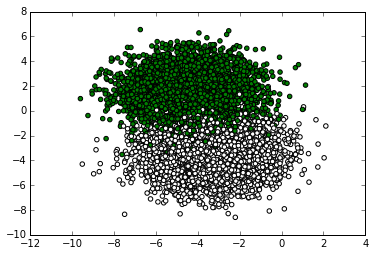

In [6]:
plt.scatter(trainX[:, 0], trainX[:, 1], marker='o', c=trainY, cmap = ('ocean'))

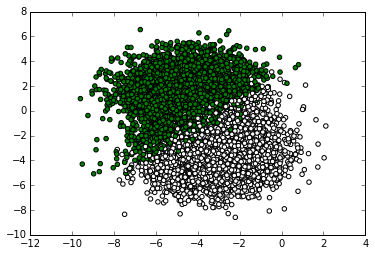

In [7]:
plt.scatter(trainX[:, 0], trainX[:, 1], marker='o', c=labels_, cmap = ('ocean'))

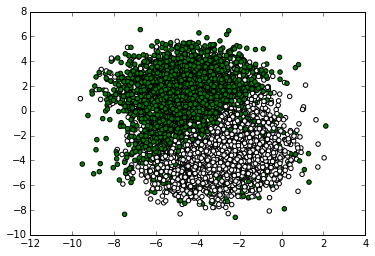

In [8]:
plt.scatter(trainX[:,0], trainX[:,1], c=np.array(lpd.labels_.collect()), cmap = (('ocean')))

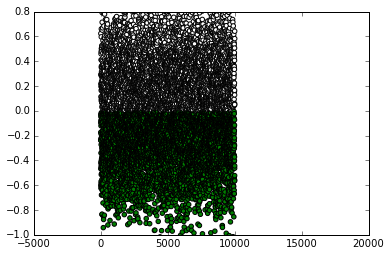

In [9]:
plt.axis([-5000,20000,-1.0,0.8])
plt.scatter(range(len(f)),f, marker='o', c=labels_,cmap=('ocean'))

In [10]:
tl = np.array(lpd.ec.map(lambda x: x[0]).collect())


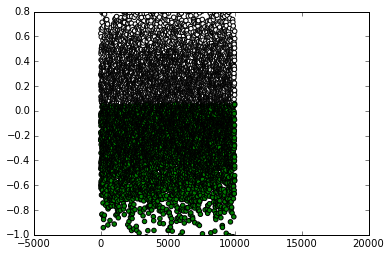

In [11]:
plt.axis([-5000,20000,-1.0,0.8])
plt.scatter(range(len(tl)),tl, marker='o', c=lpd.labels_.collect(),cmap=('ocean'))

In [12]:
np.where(np.array(lpd.labels_.collect())!=trainY)[0].shape

(2859,)

In [13]:
np.where(trainY!=labels_)[0].shape

(1402,)

In [ ]:
newf = [round(el,1) for el in f]
newec = [round(el1,1) for el1 in lpd.ec.collect()]


In [ ]:
count=0
for i in range(len(newf)):
    if round(newf[i],1) != round(newec[i],1) and abs(round(newf[i],1) - round(newec[i],1)) > 0.5:
        count = count +1
        print (newf[i],newec[i])
print count        

In [ ]:
import numpy as np

def estimateCovariance(df):
    """Compute the covariance matrix for a given dataframe.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        df:  A Spark dataframe with a column named 'features', which (column) consists of DenseVectors.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input dataframe.
    """
    m = df.select(df['features']).rdd.map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df['features']).rdd.map(lambda x:   x[0]).map(lambda x: x-m)  # subtract the mean

    return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

from numpy.linalg import eigh

def pca(df, k=k):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
        scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
        rows equals the length of the arrays in the input `RDD` and the number of columns equals
        `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
        of length `k`.  Eigenvalues is an array of length d (the number of features).
     """
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvals
    score = df.select(df['features']).rdd.map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    # Return the `k` principal components, `k` scores, and all eigenvalues

    return components.T, score, eigVals

In [ ]:
df = sc.parallelize(trainX).map(lambda vec: Row(features = DenseVector(vec))).toDF()
comp, score, eigVals = pca(df,k=dim)